<h1> <u> Projet Informatique - Optimisation d'un réseau de livraison </u> </h1>

<h2> Document complémentaire : améliorations du programme</h2>

Ce document n'est pas nécessaire à la compréhension du fonctionnement de l'algorithme, cependant il présente quelques exemples d'améliorations successives que nous avons apportées à notre programme.

**Note : ne pas réexécuter les cellules !**

### Importations nécessaires

In [2]:
import networkx as nx
import osmnx as ox
import pandas as pd
import csv
import geopandas
import time

### Gain de temps sur la création du graphe de l'Ile-de-France

L'exécution de notre programme nécessite le calcul du graphe networkx du réseau routier d'Île-de-France. Nous avons remarqué que le calcul de ce graphe était assez long, et avons donc cherché à pallier ce problème

#### <font color = "blue"> 1ère version : Calcul du graphe de l'Île-de-France directement dans le programme  </font>

Dans un premier temps, les lignes de code suivantes étaientt exécutées directement dans notre programme :

In [111]:
start_time = time.time()

G_idf_0 = ox.graph_from_place('Ile-de-France, France', network_type='drive', simplify=True)

# Adding speeds (kph) and travel times (seconds) to the graph's edges
ox.speed.add_edge_speeds(G_idf_0)
ox.speed.add_edge_travel_times(G_idf_0)

print("Temps d'exécution : %s secondes ---" % (time.time() - start_time))

Temps d'exécution : 608.9809300899506 secondes ---


On remarque que cette ligne de code met plus de 10 minutes à s'exécuter ! Nous avons donc cherché à réduire ce temps de calcul.

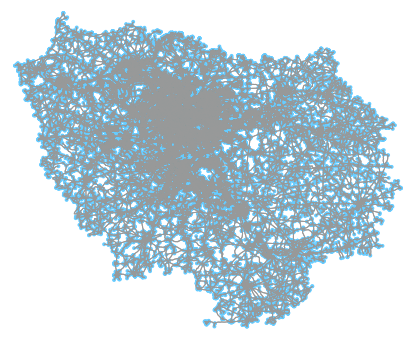

(<Figure size 805.654x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8e4ba84550>)

In [8]:
ox.plot_graph(G_idf_0)

#### <font color = "blue"> 2ème version : Sauvegarde du graphe dans un fichier csv  </font>

Plutôt que de recalculer le graphe de l'Île-de-France à chaque fois que l'on utilise le programme, nous avons cherché un moyen de le sauvegarder en local.
La première solution que nous avons trouvée est de sauvegarder le graphe sous forme de deux fichiers csv :
- le premier contenant les informations relatives aux noeuds du graphe
- le second contenant les informations relatives aux arêtes du graphe

In [103]:
# Converting the graph into geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_idf_0)

# Converting the geodataframes into csv files (in order to store the data)
gdf_nodes.to_csv("./saved_files/gdf_nodes_idf.csv")
gdf_edges.to_csv("./saved_files/gdf_edges_idf.csv")

# Creating a smaller version of gdf_edges (in order to use it on GitHub)
gdf_edges_simplified = gdf_edges.drop(labels=["highway","area","junction","bridge","access","tunnel","width","est_width", "ref", "maxspeed", "lanes", "service", "name"], axis=1)
gdf_edges_simplified.to_csv("./saved_files/gdf_edges_idf_simplified.csv")

Dans notre programme, le graphe de l'Île-de-France est ainsi calculé à partir de ces deux fichiers csv plutôt que d'être recalculé depuis zéro, à l'aide du script suivant :

In [105]:
start_time = time.time()

# Loading graph of Ile-de-France

df_nodes_idf = pd.read_csv("gdf_nodes_idf.csv", index_col="osmid", dtype = {'osmid': int, 'y': float, 'x': float})
df_edges_idf = pd.read_csv("gdf_edges_idf_simplified.csv")
df_nodes_idf.drop(labels = "Unnamed: 0", axis = 1, inplace = True)
df_edges_idf.drop(labels = "Unnamed: 0", axis = 1, inplace = True)

gdf_nodes_idf = geopandas.GeoDataFrame(df_nodes_idf)
gdf_edges_idf = geopandas.GeoDataFrame(df_edges_idf)

G_idf_from_csv = ox.utils_graph.graph_from_gdfs(gdf_nodes_idf, gdf_edges_idf)

print("Temps d'exécution : %s secondes ---" % (time.time() - start_time))

Temps d'exécution : 100.16215205192566 secondes ---


On remarque qu'on gagne du temps avec cette méthode : le script met environ une minute à s'exécuter au lieu de 10 minutes !

Cette méthode présente tout de même un inconvénient : le fichier csv contenant les informations relatives aux arêtes du graphe pèse plus de 100 MB ce qui empêche de le partager via GitHub. D'où la création d'une version allégée de ce fichier, qui contient uniquement les informations indispensables.

#### <font color = "blue"> 3ème version : Sauvegarde du graphe sous format pickle  </font>

On utilise ici une autre manière de sauvegarder en local le graphe de l'Île-de-France : le format pickle

In [115]:
nx.write_gpickle(G_idf_0, "./graph_idf.gpickle")

Dans notre programme, il suffit alors d'exécuter la ligne de code suivante pour avoir accès au graphe de l'Île-de-France :

In [107]:
start_time = time.time()

G_idf_from_pickle = nx.read_gpickle("./saved_files/graph_idf.gpickle")

print("Temps d'exécution : %s secondes ---" % (time.time() - start_time))

Temps d'exécution : 5.748719930648804 secondes ---


On remarque qu'on gagne encore du temps avec cette méthode : seulement 6 secondes pour charger le graphe du réseau routier d'Île-de-France ! 

La sauvegarde du graphe sous forme de deux fichiers csv n'aura cependant pas été inutile, puisqu'on utilise aussi dans certaines parties de l'algorithme les informations sur les noeuds de ce graphe, auxquelles on peut avoir accès facilement par la méthode pandas.read_csv appliquée au fichier "gdf_nodes_idf.csv"

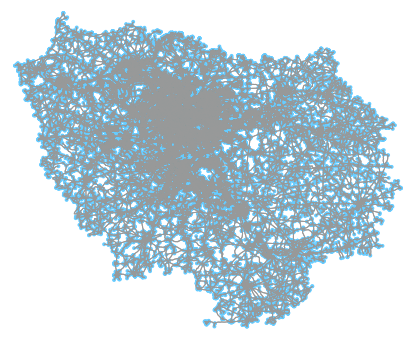

(<Figure size 805.654x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff2cee4c370>)

In [72]:
ox.plot_graph(G_idf_from_pickle)

### Correction des temps de trajet

En comparant certains temps de trajet trouvés par notre algorithme à ceux calculés par Google Maps, nous nous sommes aperçues que notre programme avait tendance à sous estimer les temps de trajet. Cela peut-être dû à la non prise en compte des feux de circulation du traffic dans le calcul des temps de trajet des arêtes du graphe du réseau routier d'Île-de-France.


Pour essayer de corriger ce problème, nous avons donc décidé d'ajouter aux arêtes de ce graphe un attribut "corrected_travel_time", qui est le temps de trajet existant augmenté de 20%.

In [112]:
# création d'un dictionnaire qui a chaque arête du graphe de l'Ile-de-France (clé)
#  associe le temps de trajet corrigé (valeur)
dict_ = {}
travel_times = nx.get_edge_attributes(G_idf_0, 'travel_time')
for key, value in travel_times.items():
    dict_[key] = value * 1.2

In [113]:
# ajout de l'attribut temps de trajet corrigé aux arêtes du graphe
nx.set_edge_attributes(G_idf_0, dict_, 'corrected_travel_time')

Comme on peut le voir avec la cellule suivante, l'attribut "corrected_travel_time" a bien été ajouté pour toutes les arêtes du graphe du réseau routier d'Île-de-France :

In [110]:
df_idf_new = nx.to_pandas_edgelist(G_idf_0)
df_idf_new

,source,target,bridge,corrected_travel_time,travel_time,maxspeed,geometry,length,tunnel,width,...,osmid,junction,lanes,name,area,highway,service,oneway,est_width,access
0,139460608,139489286,NaN,12.24,10.2,NaN,"LINESTRING (2.1055331 48.7878895, 2.1053893 48...",156.584,NaN,NaN,...,14358639,NaN,NaN,NaN,NaN,primary,NaN,True,NaN,NaN
1,139460608,1903816043,NaN,22.20,18.5,70,"LINESTRING (2.1055331 48.7878895, 2.105433 48....",359.212,NaN,NaN,...,"[14358372, 31110862, 52407183]",NaN,2,Route de la Minière,NaN,secondary,NaN,True,NaN,NaN
2,2295332864,836110502,NaN,7.68,6.4,NaN,"LINESTRING (2.232004 48.8759415, 2.2321343 48....",79.349,NaN,NaN,...,54563293,NaN,2,Rue de Verdun,NaN,tertiary,NaN,False,NaN,NaN
3,2295332864,840952129,NaN,0.96,0.8,50,"LINESTRING (2.232004 48.8759415, 2.2319828 48....",11.114,NaN,NaN,...,684085643,circular,2,Rue de Verdun,NaN,tertiary,NaN,True,NaN,NaN
4,297271300,297271314,NaN,41.16,34.3,NaN,"LINESTRING (2.2140712 48.6306538, 2.2148494 48...",422.080,NaN,NaN,...,27093452,NaN,NaN,Chemin de Trou,NaN,unclassified,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514698,7179599870,314357090,NaN,29.88,24.9,NaN,"LINESTRING (2.1310275 48.8876256, 2.1308718 48...",261.781,NaN,NaN,...,"[29166260, 362068164, 362068167]",NaN,2,Avenue Georges Clemenceau,NaN,residential,NaN,False,NaN,NaN
514699,7179599870,314357062,NaN,35.40,29.5,NaN,"LINESTRING (2.1310275 48.8876256, 2.1315282 48...",309.341,NaN,NaN,...,769123273,NaN,2,Avenue Georges Clemenceau,NaN,residential,NaN,False,NaN,NaN
514700,301465599,301466000,NaN,1.08,0.9,50,NaN,12.178,NaN,NaN,...,27456567,NaN,1,Rue des Franchises,NaN,residential,NaN,True,NaN,NaN
514701,301465599,6241387242,NaN,1.32,1.1,NaN,"LINESTRING (2.2802868 48.9884214, 2.2802466 48...",13.338,NaN,NaN,...,27456518,NaN,NaN,Rue d'Enghien,NaN,tertiary,NaN,False,NaN,NaN
